* Moving Average Line 기법
    - 상승과 하강이후에 매수와 매매 신호 발생
    - 타이밍 느림
    - 변폭이 높은 투자 상황에서 불리
* MACD(이동 평균 수렴 확산 지수)
    - Moving Average Convergence Divergence
    - 장단기 이동평균선의 차이를 이용하여 매매신호를 포착하려는 기법
    - 원리
        * 단이평선이 장이평선위로 많이 멀어지게 되면(Divergence)하락할때가 됬다.
        * 단이평선이 장이평선 아래로 많이 멀어졌다 가까워지면 살때가 됬다
    - MAL 기법의 단점인 타이밍 극복
    - 장단기 이평선의 지수이동평균을 사용하여 타이밍 확보
        - 단순이동평균보다 지수이동평균은 최근의 데이터에 더 가중치 부여
        
* RSI: 상대 강도 지수:relative strength index
    - MACD처럼 상승 하강의 압력의 아이디어에서 출발
        - 기간평균이 아닌 오름과 내림의 구분을 통한 평균 계산
    - 일정 기간 동안 주가가 전일 가격대비 상승분 하락한분 평균값 
    - 상승한 변화량이 크면 과매수로, 하락한 변화량이 크면 과매도 판단
    - 계산
        * 전일 가격보다 상승한 날의 상승분의 평균 AU(average ups)
        * 전일 가격보다 하락한 날의 하락분의 평균 AD(average downs)
        * RS(relative strength) AU/AD : 크면 상승폭이 컸음
        * RSI = RS / (1 + RS)
        * RSI = AU / (AU + AD)

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 베이스 사용하기 SQLITE3
startday='2021-07-01'
def seldata(dstart=startday,dend='2021-12-20'):
    dbname='../_db/stockdb.db'
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        cols='sday,sopenp,shighp,slowp,sclosep,svol'
        selsql="select "+cols+" from stockp where sday>='"+dstart+"' and sday<='"+dend+"' order by sday asc"
        sdata=cur.execute(selsql).fetchall()
    return sdata

In [3]:
sdata=seldata()
cols=['sday','sopenp','shighp','slowp','sclosep','svol']
sdf=pd.DataFrame(sdata,columns=cols)
tdf=sdf.set_index('sday')
tdf.head()

,sopenp,shighp,slowp,sclosep,svol
sday,,,,,
2021-07-01,31250,31800,32150,31200,1641174
2021-07-02,31350,31300,31600,31300,1022673
2021-07-05,31850,31600,32250,31250,2594913
2021-07-06,32250,32050,32650,32000,1955885
2021-07-07,31500,31800,31800,31300,1885914


<AxesSubplot:xlabel='sday'>

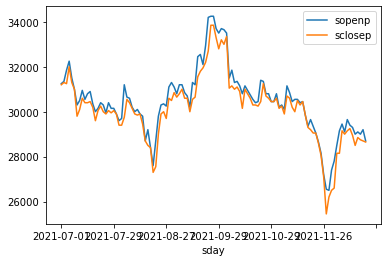

In [22]:
tdf[['sopenp','sclosep']].plot()

In [59]:
### U D 를 만들기
wsize=10
sigwin=5
beforep=tdf.iloc[0,:]['sclosep'] # 시작가

for i, row in tdf[['sclosep']].iterrows():
    if row['sclosep']>=beforep:
        tdf.loc[i,'U']=row['sclosep']-beforep
        tdf.loc[i,'D']=0
    else:
        tdf.loc[i,'D']=beforep-row['sclosep']
        tdf.loc[i,'U']=0
    beforep=row['sclosep']

tdf['AU']=tdf['U'].rolling(window=wsize).mean()
tdf['AD']=tdf['D'].rolling(window=wsize).mean()
wdf=tdf.fillna(0)
wdf['RSI']=wdf['AU']/(wdf['AD']+wdf['AU']+0.0001)
wdf['Rsig']=wdf['RSI'].rolling(window=sigwin).mean()
wdf=wdf.fillna(0)
wdf.head()

,sopenp,shighp,slowp,sclosep,svol,D,U,AU,AD,RSI,Rsig
sday,,,,,,,,,,,
2021-07-01,31250,31800,32150,31200,1641174,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-02,31350,31300,31600,31300,1022673,0.0,100.0,0.0,0.0,0.0,0.0
2021-07-05,31850,31600,32250,31250,2594913,50.0,0.0,0.0,0.0,0.0,0.0
2021-07-06,32250,32050,32650,32000,1955885,0.0,750.0,0.0,0.0,0.0,0.0
2021-07-07,31500,31800,31800,31300,1885914,700.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='sday'>

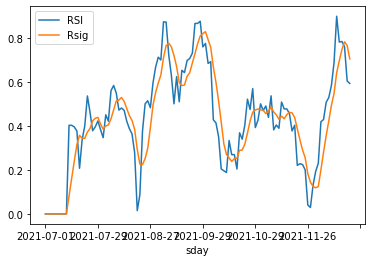

In [60]:
wdf[['RSI','Rsig']].plot()

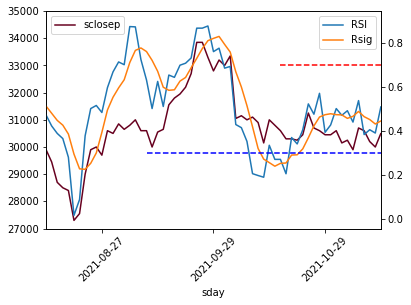

In [61]:
fig,ax1=plt.subplots()

wdf[['sclosep']].plot( ax=ax1,cmap='RdBu')
ax1.legend(loc=1)
plt.xticks(rotation=45)
plt.ylim(27000,35000,ax1)
ax2 = ax1.twinx()
wdf[['RSI','Rsig']].plot(ax=ax2)
ax1.legend(loc=2)

plt.xticks(rotation=45)
ax2.axhline(0.3,0.3,30,color='b',linestyle='--')
ax2.axhline(0.7,0.7,30,color='r',linestyle='--')
plt.xlim(30,90)
plt.show()

In [62]:
# 2개월간 10
beforepos=-1 # RSI 포지션
beforehold=0 # 주식 보유여부
for i,row in wdf.iloc[:,:].iterrows():
    #print(i,'\n',row)
    
    if row['RSI']>row['Rsig']:
        nowpos=1 ## 매수 포지션
    else:
        nowpos=-1
    if(row['AU']==0):
        nowpos=-1
    wdf.loc[i,'nowpos']=nowpos # 현재 포지션
    
    if nowpos>beforepos and beforehold==0: # 매수신호
        timing=1
        hold=1
        wdf.loc[i,'cash']=-row['sclosep']
    elif nowpos<beforepos and beforehold==1:
        timing=-1
        hold=0
        wdf.loc[i,'cash']=row['sclosep']
    else:
        timing=0
        hold=beforehold
        wdf.loc[i,'cash']=0
        
    wdf.loc[i,'hold']=hold # 주식 보유 여부
    wdf.loc[i,'timing']=timing
    beforepos=nowpos
    beforehold=hold
wdf.loc[startday,'cash']=32000
wdf['cumcash']=wdf['cash'].cumsum()
wdf['balance']=wdf['sclosep']*wdf['hold']+wdf['cumcash']
scols=['sclosep','RSI','nowpos','timing','hold','cash','cumcash','balance']
print('시작가:',wdf['sclosep'][0],
      ' 종가:',wdf['sclosep'][-1],
      '차이:',wdf['sclosep'][-1]-wdf['sclosep'][0],
      '잔고:',wdf['balance'][-1],
      '수익:',wdf['balance'][-1]-wdf['balance'][0],
     )
wdf[scols].head(30)


시작가: 31200  종가: 28650 차이: -2550 잔고: 34800.0 수익: 2800.0


,sclosep,RSI,nowpos,timing,hold,cash,cumcash,balance
sday,,,,,,,,
2021-07-01,31200,0.000000,-1.0,0.0,0.0,32000.0,32000.0,32000.0
2021-07-02,31300,0.000000,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-05,31250,0.000000,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-06,32000,0.000000,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-07,31300,0.000000,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-08,31000,0.000000,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-09,29800,0.000000,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-12,30100,0.000000,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-13,30600,0.000000,-1.0,0.0,0.0,0.0,32000.0,32000.0
